<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/CNN_%2B_ViT_%2B_GRU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.99GB/s]


In [4]:
import zipfile

zip_path = '/content/brain-tumor-mri-dataset.zip'
extract_to = 'brain_tumor_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [5]:
batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/brain_tumor_data/Training',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/brain_tumor_data/Training',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
class ViTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(ViTBlock, self).__init__()
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.drop1 = layers.Dropout(dropout_rate)

        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim)
        ])
        self.drop2 = layers.Dropout(dropout_rate)

    def call(self, x):
        attn_out = self.attn(x, x)
        x = x + self.drop1(attn_out)
        x = self.norm1(x)
        mlp_out = self.mlp(x)
        x = x + self.drop2(mlp_out)
        return self.norm2(x)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_cnn_vit_gru(input_shape=(128, 128, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # CNN base with L2
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D()(x)

    # Reshape for ViT
    x = layers.Reshape((-1, 128))(x)

    # ViT Block
    x = ViTBlock(embed_dim=128, num_heads=4, mlp_dim=256)(x)

    # GRU
    x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)

    # Output with Dropout
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_cnn_vit_gru()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.4113 - loss: 1.3926 - val_accuracy: 0.6918 - val_loss: 0.8565 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6235 - loss: 0.9466 - val_accuracy: 0.7207 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6936 - loss: 0.7741 - val_accuracy: 0.7837 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7177 - loss: 0.7151 - val_accuracy: 0.8047 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7805 - loss: 0.6217 - val_accuracy: 0.8170 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7615 - loss: 0.6488 - val_accuracy: 0.8494 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7801 - loss: 0.

In [ ]:
# ist
# def build_cnn_vit_gru(input_shape=(128, 128, 3), num_classes=4):
#     inputs = layers.Input(shape=input_shape)

#     # CNN base
#     x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D()(x)

#     # Flatten spatial dims to sequence
#     x = layers.Reshape((-1, 128))(x)  # shape = (batch, time_steps, features)

#     # ViT Block
#     x = ViTBlock(embed_dim=128, num_heads=4, mlp_dim=256)(x)

#     # GRU
#     x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)

#     # Output
#     x = layers.Dense(64, activation='relu')(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs, outputs)
#     return model


In [ ]:
# model = build_cnn_vit_gru()
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

# history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_block (ViTBlock)           │ (None, 256, 128)       │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,500 (1.93 MB)

 Trainable params: 506,500 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.5064 - loss: 1.0663 - val_accuracy: 0.7855 - val_loss: 0.5657
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8092 - loss: 0.5064 - val_accuracy: 0.8616 - val_loss: 0.4103
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8454 - loss: 0.4111 - val_accuracy: 0.8660 - val_loss: 0.3999
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8468 - loss: 0.3980 - val_accuracy: 0.8879 - val_loss: 0.3360
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8553 - loss: 0.3785 - val_accuracy: 0.8310 - val_loss: 0.4518
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8621 - loss: 0.3645 - val_accuracy: 0.8695 - val_loss: 0.3756
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.8708 - loss: 0.3594 - val_accuracy: 0.8853 - val_loss: 0.3315
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8926 - loss: 0.3010 - val_accu

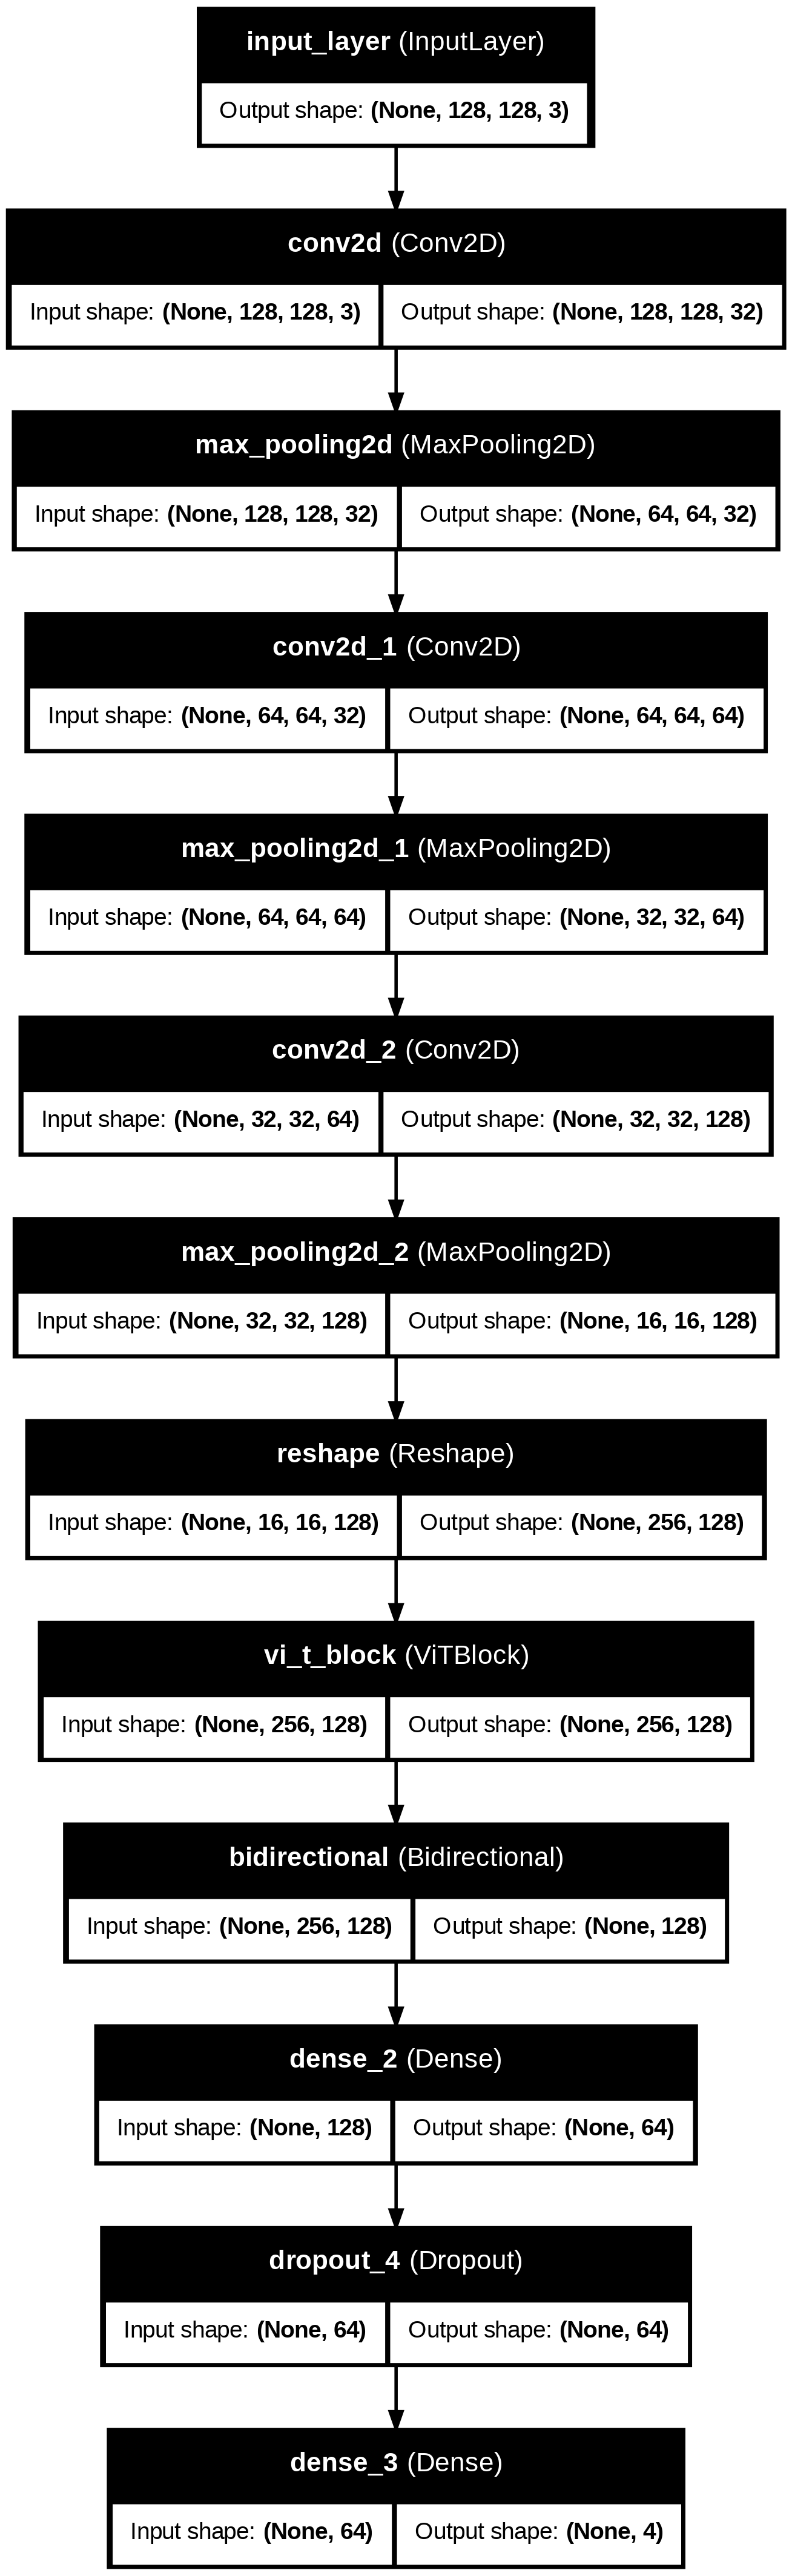

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


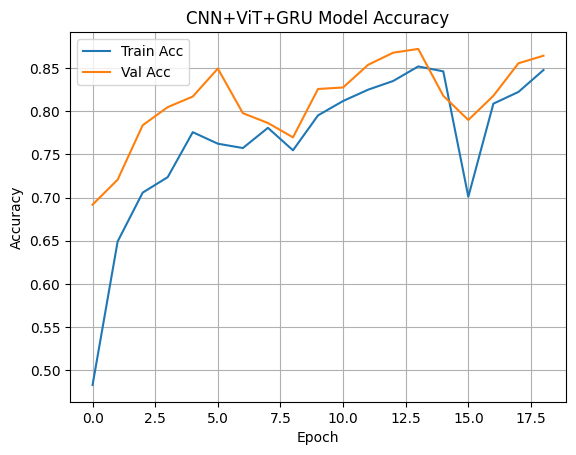

In [10]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN+ViT+GRU Model Accuracy')
plt.grid(True)
plt.show()


In [ ]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_acc * 100:.2f}%")

In [ ]:
# import numpy as np
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, cohen_kappa_score, confusion_matrix, classification_report
# )
# import seaborn as sns
# import matplotlib.pyplot as plt

In [ ]:
# # === Make Predictions ===
# y_pred_probs = model.predict(X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)
# y_true = np.argmax(y_test, axis=1)

In [ ]:
# # === Compute Metrics ===
# acc = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='macro')
# recall = recall_score(y_true, y_pred, average='macro')
# f1 = f1_score(y_true, y_pred, average='macro')
# kappa = cohen_kappa_score(y_true, y_pred)

In [ ]:
# === Print Metrics ===
# print(f"Accuracy      : {acc:.4f}")
# print(f"Precision     : {precision:.4f}")
# print(f"Recall        : {recall:.4f}")
# print(f"F1 Score      : {f1:.4f}")
# print(f"Cohen's Kappa : {kappa:.4f}")

In [ ]:
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred))

# # === Confusion Matrix ===
# cm = confusion_matrix(y_true, y_pred)

In [ ]:
# === Plot Confusion Matrix ===
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [11]:
# Make Predictions & Get True Labels

import numpy as np

# Make predictions on the test/validation dataset
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)


36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step


In [ ]:
# Test Accuracy (manual)
test_accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")



Test Accuracy: 0.2487


In [ ]:
# sklearn Metrics: Accuracy, Precision, Recall, F1, Cohen’s Kappa

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


Accuracy: 0.2487
Precision: 0.2483
Recall: 0.2487
F1 Score: 0.2484
Cohen's Kappa: -0.0092


In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 46  45  94  59]
 [ 39  54  74  82]
 [ 68  81  97 102]
 [ 63  66  92  80]]


In [13]:
# Full Classification Report
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

      glioma       0.21      0.19      0.20       244
  meningioma       0.22      0.22      0.22       249
     notumor       0.27      0.28      0.28       348
   pituitary       0.25      0.27      0.26       301

    accuracy                           0.24      1142
   macro avg       0.24      0.24      0.24      1142
weighted avg       0.24      0.24      0.24      1142



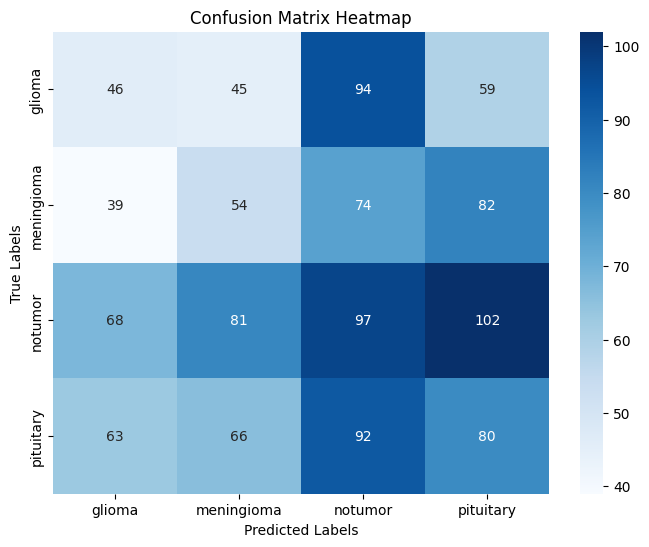

In [16]:
# Plot Confusion Matrix Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
